# parse

In [28]:
import os
import wandb
from tqdm import tqdm
import time
import json
import pandas as pd
import re

In [29]:
# https://wandb.ai/seosh7039/lingua/workspace?nw=nwuserseosh7039
api = wandb.Api()
username = "seosh7039"
project_name = "lingua"
project_path = f"{username}/{project_name}"
runs = api.runs(project_path)

num_runs = len(runs)
all_runs_data = {}
save_dir = "./assets/wandb"
file_name = "mup_sweep.json"
file_path = os.path.join(save_dir, file_name)

if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        all_runs_data = json.load(file)
    print("Data loaded from JSON file")
else:
    print("Data does not exists, you should parse from scratch")

Data does not exists, you should parse from scratch


In [49]:
# Function to parse parameters from run_name with default False for ngpt
def parse_run_name(run_name):
    nhead = re.search(r'_nhead_(\d+)', run_name)
    nkvhead = re.search(r'_nkvhead_(\d+)', run_name)
    lr = re.search(r'_lr_([0-9.]+)', run_name)
    qknorm = re.search(r'_qknorm_(true|false)', run_name, re.IGNORECASE)
    resnorm = re.search(r'_resnorm_(true|false)', run_name, re.IGNORECASE)
    ngpt = re.search(r'_ngpt_(true|false)', run_name, re.IGNORECASE)
    
    return {
        'nhead': int(nhead.group(1)) if nhead else None,
        'nkvhead': int(nkvhead.group(1)) if nkvhead else None,
        'lr': float(lr.group(1)) if lr else None,
        'qknorm': qknorm.group(1).lower() == 'true' if qknorm else None,
        'resnorm': resnorm.group(1).lower() == 'true' if resnorm else None,
        'ngpt': ngpt.group(1).lower() == 'true' if ngpt else False,  # Default to False if ngpt is None
    }

def make_json_serializable(data):
    """Recursively convert numpy and pandas types within a dictionary to native Python types."""
    if isinstance(data, dict):
        return {key: make_json_serializable(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [make_json_serializable(element) for element in data]
    elif isinstance(data, (int, float, str, bool)) or data is None:
        return data
    else:
        # Convert numpy and similar types to native Python types
        return data.item() if hasattr(data, "item") else data
    
def get_config_value(config, key):
    if key in config.keys():
        return config[key]
    else:
        return False
        
def parse_data_from_runs(
    all_runs_data,
    runs, 
    target_global_step=40000,
    max_retries=3,
):
    skipped = 0
    
    for run in tqdm(runs):
        try:
            # Check if the run is finished
            if run.state != "finished":
                skipped += 1
                print(f"Run {run.name} is not finished, skipping.")
                continue

            if run.id in all_runs_data.keys():
                continue

            retries = 0
            while retries < max_retries:
                try:
                    # Fetch the history with only 'loss/out' and 'global_step'
                    history_df = run.history(keys=["loss/out", "global_step"], pandas=True)
                    history_df['run_id'] = run.id
                    history_df['run_name'] = run.name
                    config = run.config
                    
                    nhead = get_config_value(config['model'], 'n_heads')
                    nkvhead = get_config_value(config['model'], 'n_kv_heads')
                    lr = get_config_value(config['optim'], 'lr')
                    qk_norm = get_config_value(config['model'], 'qk_norm')
                    resnorm = get_config_value(config['model'], 'residual_post_norm')
                    ngpt = get_config_value(config['model'], 'ngpt')
                    truly_decoupled_wd = get_config_value(config['optim'], 'truly_decoupled_wd')
                    residual_value = get_config_value(config['model'], 'residual_value')

                    # Ensure we have at least 20 valid loss values
                    last_step = history_df["global_step"].max()
                    last_20_losses = history_df["loss/out"].tail(20).dropna()
                    if last_step != target_global_step:
                        print(f"last_step ({last_step}) != target_global_step ({target_global_step})")
                        break

                    if len(last_20_losses) == 20:
                        # Calculate the average of the last 20 loss entries
                        avg_loss = last_20_losses.mean()

#                         # Parse run_name to extract parameters
#                         parsed_params = parse_run_name(run.name)
                        parsed_params = {
                            'nhead': nhead,
                            'nkvhead': nkvhead,
                            'lr': lr,
                            'qk_norm': qk_norm,
                            'resnorm': resnorm,
                            'ngpt': ngpt,
                            'truly_decoupled_wd': truly_decoupled_wd,
                            'residual_value': residual_value,
                        }
    
                        # Combine parsed parameters with the main data
                        parsed_data = {
                            "run_id": run.id, 
                            "run_name": run.name,
                            "global_step": int(last_step),
                            "avg_loss_last_20": float(avg_loss),
                        }
                        parsed_data.update(parsed_params)  # Add parsed params to data
                        all_runs_data[run.id] = parsed_data
                    else:
                        print(f"Run {run.name} has less than 20 valid loss entries, skipping.")

                    # If data is fetched successfully, exit the retry loop
                    break

                except Exception as e:
                    retries += 1
                    print(f"Error fetching data for run {run.id} (attempt {retries}): {e}")
                    time.sleep(2.0)  # Small delay before retrying

            # If max retries reached and data couldn't be fetched, log the issue
            if retries == max_retries:
                print(f"Failed to fetch data for run {run.id} after {max_retries} attempts, skipping.")

        except Exception as e:
            print(f"Unexpected error processing run {run.id}: {e}")
            continue  # Skip runs that fail
    return all_runs_data, skipped

all_runs_data, skipped = parse_data_from_runs(all_runs_data, runs)
        
assert (num_runs-skipped) == len(all_runs_data.keys()), f'''
(num_runs-skipped) ({num_runs-skipped}) != len(all_runs_data.keys()) ({len(all_runs_data.keys())})
please retry to fully parse data from runs
'''

all_runs_data = make_json_serializable(all_runs_data)
with open(file_path, 'w') as file:
    json.dump(all_runs_data, file, indent=4)
print(f"(Overrided) Data saved to {file_path}")

filtered_runs_df = pd.DataFrame(all_runs_data.values())
print(f'''
len(runs): {len(runs)}
skipped: {skipped}
''')

print(filtered_runs_df)

  0%|                                                                                                                                                                                                                                          | 0/71 [00:00<?, ?it/s]

Run mup_true_nhead_16_nkvhead_4_basenhead_4_basenkvhead_1_world_8_DP_2_SHARD_4_TP_1_fsdp_full_shard_compile_true_step_40000_warmup_1000_bsz_4_accum_1_lr_0.00098_qknorm_false_resnorm_false_ngpt_false_wd_.000098_optim_adamw is not finished, skipping.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 129.78it/s]

Run test shampoo v1 is not finished, skipping.
Run mup_true_nhead_32_nkvhead_8_basenhead_4_basenkvhead_1_world_8_DP_1_SHARD_8_TP_1_fsdp_full_shard_compile_true_step_40000_warmup_1000_bsz_2_accum_2_lr_0.00098_qknorm_false_resnorm_false_ngpt_false_wd_0.1_optim_adamw is not finished, skipping.
Run probing and profiling test is not finished, skipping.
(Overrided) Data saved to ./assets/wandb/mup_sweep.json

len(runs): 71
skipped: 4

      run_id                                           run_name  global_step  \
0   purjtw94  mup_true_nhead_8_nkvhead_2_basenhead_4_basenkv...        40000   
1   ehacrjhz  mup_true_nhead_8_nkvhead_2_basenhead_4_basenkv...        40000   
2   dhrszotp  mup_true_nhead_8_nkvhead_2_basenhead_4_basenkv...        40000   
3   zj6kpxdh  mup_true_nhead_4_nkvhead_1_basenhead_4_basenkv...        40000   
4   s19qnfib  mup_true_nhead_16_nkvhead_4_basenhead_4_basenk...        40000   
..       ...                                                ...          ...   
62  4in

# plot

/tmp/ipykernel_125079/633094094.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_groups))


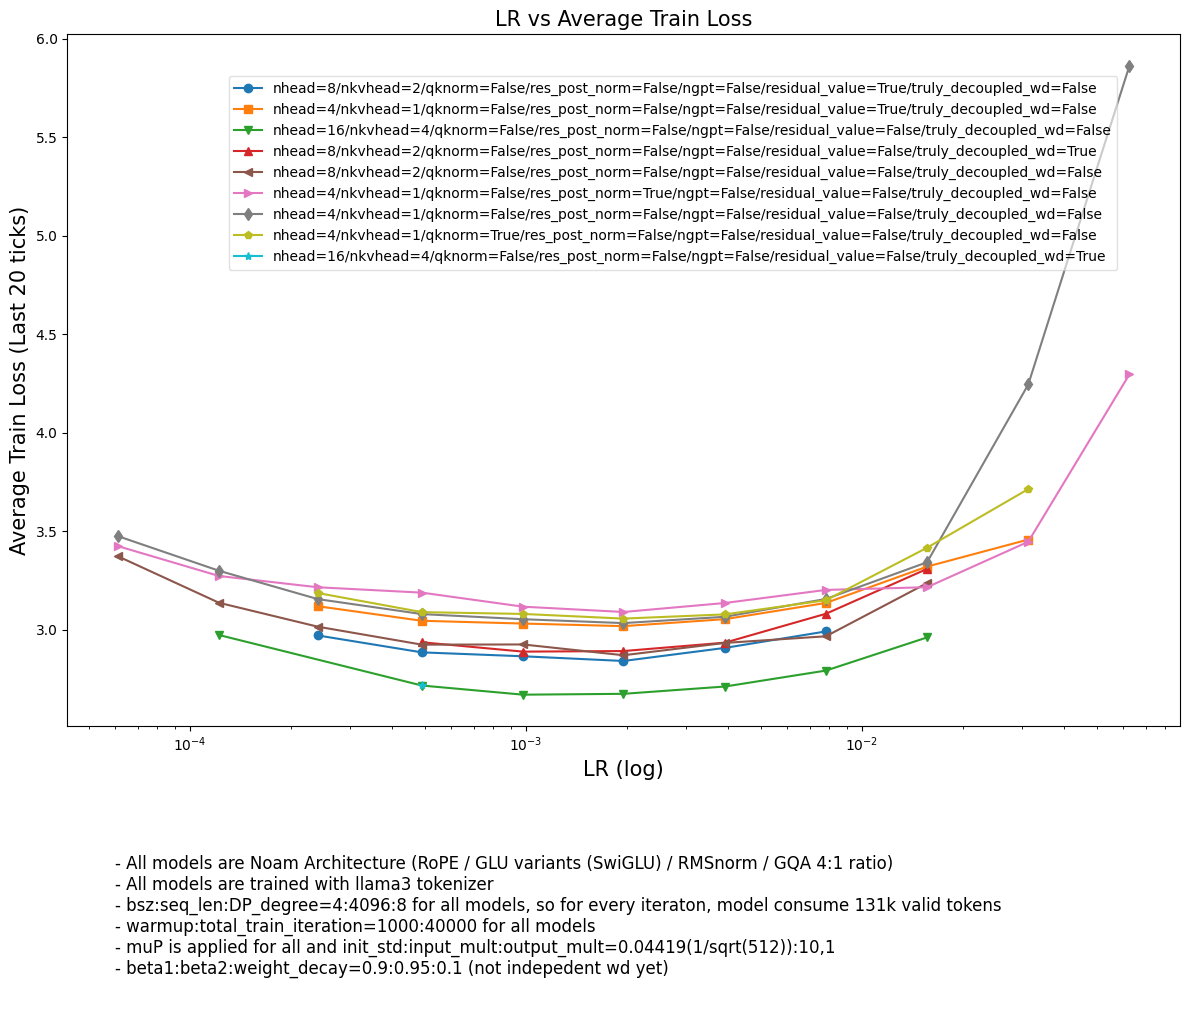

In [51]:
import matplotlib.pyplot as plt

titlesize = 15
fontsize = 10
note_fontsize = 12
loglog = True


# Create a unique identifier for each group based on the grouping parameters
filtered_runs_df['group_id'] = filtered_runs_df.apply(
    lambda row: f"nhead={row['nhead']}/nkvhead={row['nkvhead']}/qknorm={row['qk_norm']}/res_post_norm={row['resnorm']}/ngpt={row['ngpt']}/residual_value={row['residual_value']}/truly_decoupled_wd={row['truly_decoupled_wd']}",
    axis=1
)

# Get the unique groups
unique_groups = filtered_runs_df['group_id'].unique()

# Define colors and markers
colors = plt.cm.get_cmap('tab10', len(unique_groups))
markers = ['o', 's', 'v', '^', '<', '>', 'd', 'p', '*', 'h']

plt.figure(figsize=(12, 8))

for idx, group in enumerate(unique_groups):
    group_data = filtered_runs_df[filtered_runs_df['group_id'] == group]
    
    # Sort group data by 'lr' in ascending order for smoother line connections
    group_data = group_data.sort_values(by='lr')
        
    # Plot each group with a line, ensuring it’s sorted by 'lr'
    plt.plot(
        group_data['lr'],
        group_data['avg_loss_last_20'],
        marker=markers[idx % len(markers)],
        linestyle='-',
        color=colors(idx),
        label=group
    )

plt.title('LR vs Average Train Loss', fontsize=titlesize)
xlabel = 'LR'
if loglog:
    plt.xscale('log', base=10)
    xlabel += ' (log)'
plt.xlabel(xlabel, fontsize=titlesize)

ylabel = 'Average Train Loss (Last 20 ticks)'
plt.ylabel(ylabel, fontsize=titlesize)

# some notes
note = f'''
- All models are Noam Architecture (RoPE / GLU variants (SwiGLU) / RMSnorm / GQA 4:1 ratio)
- All models are trained with llama3 tokenizer
- bsz:seq_len:DP_degree=4:4096:8 for all models, so for every iteraton, model consume 131k valid tokens
- warmup:total_train_iteration=1000:40000 for all models
- muP is applied for all and init_std:input_mult:output_mult=0.04419(1/sqrt(512)):10,1
- beta1:beta2:weight_decay=0.9:0.95:0.1 (not indepedent wd yet)
'''
plt.figtext(0.1, -0.25, note, ha='left', fontsize=note_fontsize, color='black')

# Place legend inside with transparency
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), framealpha=0.6, fontsize=fontsize)

plt.tight_layout()
plt.show()